In [1]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b0')

In [2]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [3]:
## 학습 코드
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'  # b5

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=6)

224
Loaded pretrained weights for efficientnet-b0


In [4]:
## 데이타 로드!!
batch_size  = 16
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

## make dataset
from torchvision import transforms, datasets
data_path = 'emotion_FixedVer/'  # class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
emotion_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))
## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, tmp_idx = train_test_split(list(range(len(emotion_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(emotion_dataset, train_idx)
tmp_dataset       = Subset(emotion_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)

## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 16,  tvt : 1394 / 175 / 175


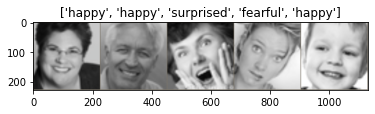

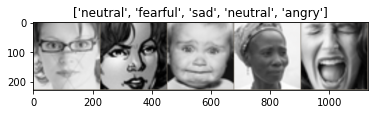

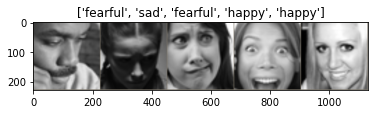

In [5]:
## 데이타 체크
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 5

class_names = {
    "0": "angry",      
    "1": "fearful",  
    "2": "happy",  
    "3": "neutral",  
    "4": "sad",  
    "5": "surprised"
}

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'EfficientNetb5_pytorch_6emotion.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu
print(torch.cuda.is_available())

True


In [8]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.001,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [9]:
batch_size  = 32

In [10]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 1.42 Acc: 43.9
valid Loss: 1.27 Acc: 50.4
==> best model saved - 0 / 50.4
Epoch 1/99
----------
train Loss: 1.13 Acc: 56.3
valid Loss: 1.06 Acc: 59.2
==> best model saved - 1 / 59.2
Epoch 2/99
----------
train Loss: 1.01 Acc: 61.3
valid Loss: 1.06 Acc: 60.2
==> best model saved - 2 / 60.2
Epoch 3/99
----------
train Loss: 0.92 Acc: 64.8
valid Loss: 1.02 Acc: 61.2
==> best model saved - 3 / 61.2
Epoch 4/99
----------
train Loss: 0.85 Acc: 68.1
valid Loss: 0.96 Acc: 64.4
==> best model saved - 4 / 64.4
Epoch 5/99
----------
train Loss: 0.78 Acc: 70.8
valid Loss: 0.95 Acc: 65.1
==> best model saved - 5 / 65.1
Epoch 6/99
----------
train Loss: 0.71 Acc: 73.6
valid Loss: 0.94 Acc: 66.1
==> best model saved - 6 / 66.1
Epoch 7/99
----------
train Loss: 0.64 Acc: 76.3
valid Loss: 1.01 Acc: 64.5
Epoch 8/99
----------
train Loss: 0.58 Acc: 78.6
valid Loss: 1.01 Acc: 66.4
==> best model saved - 8 / 66.4
Epoch 9/99
----------
train Loss: 0.50 Acc: 81.8
valid Loss:

In [11]:
print(best_acc)

68.38894869034804


In [15]:
for i in range(len(train_acc)):
    train_acc[i] = train_acc[i] / 100
for i in range(len(valid_acc)):
    valid_acc[i] = valid_acc[i] / 100

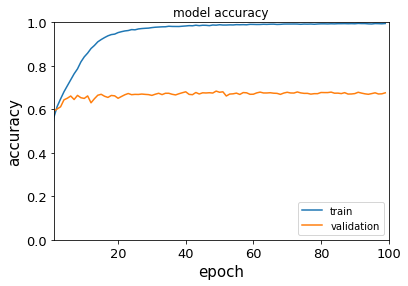

In [17]:
fig = plt.title("model accuracy")
plt.plot(train_acc)
plt.plot(valid_acc)
plt.axis([1, 100, 0, 1])
plt.ylabel("accuracy", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("epoch", fontsize=15)
plt.legend(["train", "validation"], loc="lower right")
plt.show()